In [397]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [398]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [399]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [400]:
with open('../data/filtered/bmi_steps.pickle', 'rb') as f:
    steps_bmi = pd.DataFrame(pickle.load(f))

In [401]:
printmd('**Data Overview**')
steps_bmi.head()

**Data Overview**

,user_id,year,month,day,steps,bmi
241,0009ccb4-7436-4ccd-b8e1-30fdbcee5a52,2015,3,9,10008,32.109325
242,0009ccb4-7436-4ccd-b8e1-30fdbcee5a52,2015,4,13,10270,32.109325
243,0009ccb4-7436-4ccd-b8e1-30fdbcee5a52,2015,4,14,7285,31.942263
244,0009ccb4-7436-4ccd-b8e1-30fdbcee5a52,2015,4,15,21367,32.109325
245,0009ccb4-7436-4ccd-b8e1-30fdbcee5a52,2015,4,16,6943,31.975676


In [402]:
min_entries = 60 # minimum number of bmi/steps required to compute correlations.

# Pearson Correlation

In [403]:
printmd('**Global bmi, steps correlation**')
steps_bmi[['steps','bmi']].corr()

**Global bmi, steps correlation**

,steps,bmi
steps,1.000000,-0.106789
bmi,-0.106789,1.000000


In [404]:
# Individual bmi, steps correlation
user_ids = steps_bmi.user_id.unique()
steps_bmi_user_corr = {}
i = 0
for user in user_ids:
    i = i+1
    if i%1000 == 0:
        print(i)
    steps_bmi_user = steps_bmi[steps_bmi.user_id==user]
    if(len(steps_bmi_user) < min_entries):
        continue
    corr = steps_bmi_user[['steps','bmi']].corr()['steps']['bmi']
    steps_bmi_user_corr[user] = corr

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


**Individual bmi, steps correlation**

* _Best correlation:_ -0.7388699729214743

* _Worse correlation:_ 0.7989711031674039

* _Median correlation:_ -0.0026589877982293236

* _Mean correlation:_ -0.017419850481748187

* _Standard Deviation:_ 0.17629748472718454 

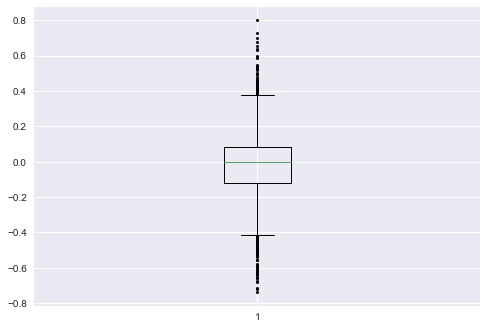

In [438]:
printmd('**Individual bmi, steps correlation**')
steps_bmi_user_corr_values = np.array([v for k,v in steps_bmi_user_corr.items()])
printmd('* _Best correlation:_ {}'.format(np.nanmin(steps_bmi_user_corr_values)))
printmd('* _Worse correlation:_ {}'.format(np.nanmax(steps_bmi_user_corr_values)))
printmd('* _Median correlation:_ {}'.format(np.nanmedian(steps_bmi_user_corr_values)))
printmd('* _Mean correlation:_ {}'.format(np.nanmean(steps_bmi_user_corr_values)))
printmd('* _Standard Deviation:_ {} '.format(np.nanstd(steps_bmi_user_corr_values)))
indexes = ~np.isnan(steps_bmi_user_corr_values)
plt.clf()
plt.boxplot(steps_bmi_user_corr_values[indexes], sym='k.')
plt.show()

In [431]:
min(steps_bmi_user_corr_values[indexes])

-0.73886997292147427

In [406]:
indexes = ~np.isnan(steps_bmi_user_corr_values)
user_idx = np.where( steps_bmi_user_corr_values[indexes] <= -0.7) [0]
len_users = len(steps_bmi_user_corr_values)
printmd('**Number of users with a strong (<=-0.7) negative correlation between steps and bmi: **{} ({}%)'.format(
    len(user_idx), "%.2f" % ( (len(user_idx)/len_users)*100)))


**Number of users with a strong (<=-0.7) negative correlation between steps and bmi: **3 (0.08%)

In [409]:
user_idx = np.where( steps_bmi_user_corr_values[indexes] >= 0.7) [0]
printmd('**Number of users with a strong (<=-0.7) positive correlation between steps and bmi: **{} ({}%)'.format(
    len(user_idx), "%.2f" % ( (len(user_idx)/len_users)*100)))


**Number of users with a strong (<=-0.7) positive correlation between steps and bmi: **2 (0.05%)

## Visualize best case of bmi vs steps correlation

**User: **d7a96a4f-cfdb-4042-8abe-a304fcd8a40b

** Min Correlation: **: -0.7388699729214743

** Scatter plot: **

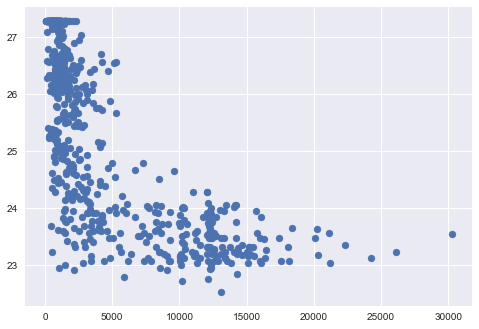

In [410]:
printmd('## Visualize best case of bmi vs steps correlation')
user_id = min(steps_bmi_user_corr, key=steps_bmi_user_corr.get)
printmd('**User: **{}'.format(user_id))
steps_bmi_user = steps_bmi[steps_bmi.user_id==user_id]
printmd('** Min Correlation: **: {}'.format(steps_bmi_user_corr[user_id]))
printmd('** Scatter plot: **')
plt.scatter(steps_bmi_user['steps'],steps_bmi_user['bmi'])
plt.show()


In [411]:
def regression_analysis(steps_bmi_user):
    # create a fitted model
    lm1 = smf.ols(formula='bmi ~ steps', data=steps_bmi_user[['bmi', 'steps']]).fit()
    # print the coefficients
    printmd('** The regression model is defined as: **bmi = _a_ + _b_ steps')
    printmd('** Linear regression coefficients: **') 
    printmd('* _a_ = {}'.format(lm1.params['Intercept']))
    printmd('* _b_ = {}'.format(lm1.params['steps']))
    
    printmd('** Linear regression predictions: **')
    X_new = pd.DataFrame({'steps': [2000]})
    printmd('* Steps: 2000, Bmi_pred: {}'.format(lm1.predict(X_new)[0]))
    X_new = pd.DataFrame({'steps': [5000]})
    printmd('* Steps: 5000, Bmi_pred: {}'.format(lm1.predict(X_new)[0]))
    X_new = pd.DataFrame({'steps': [10000]})
    printmd('* Steps: 10000, Bmi_pred: {}'.format(lm1.predict(X_new)[0]))
    
    printmd('**Plot the Least Squares Line**')
    sns.pairplot(steps_bmi_user[['steps', 'bmi']], x_vars='steps', y_vars='bmi', size=5, aspect=1.5, kind='reg')
    plt.show()
    
    printmd('** 95% confidence intervals for the model coefficients **')
    print(lm1.conf_int())
    printmd('** Confidence interval interpretation: **If the population from which this sample was drawn \
    was sampled 100 times, approximately 95 of those confidence intervals would contain the \"true\" coefficient.')
    
    printmd('### Hypothesis Test')
    printmd('** Conventional hypothesis **')
    printmd('* Null Hypothesis: There is no relationship bewteen bmi and steps (_b_ = 0)')
    printmd('* Alternative Hypothesis: There is a relationship bewteen bmi and steps (_b_ != 0)')
    printmd('** Testing hypotesis **')
    printmd('The null hypotesis is rejected if:')
    printmd('* the 95% confidence interval does not include zero')
    printmd('The null hypotesis is not rejected if:')
    printmd('* the 95% confidence interval includes zero')
    printmd('** Interpretation **')
    printmd('* Rejecting the null hypotesis means that there is a relationship bewteen bmi and steps')
    printmd('** pvalue **')
    printmd('* Represents the probability that the coefficient is actually zero')
    printmd('* If the 95% confidence interval does not include zero, p-value will be less than 0.05')
    printmd('** Compute pvalues **')
    pv = lm1.pvalues
    printmd('* _a_: {}'.format(pv['Intercept']))
    printmd('* _b_: {}'.format(pv['steps']))
    printmd('** Conclusion **')
    if pv['steps'] <= 0.05:
        printmd('pvalue for _b_ is less or equal to 0.05, which means the probability that the \
        coefficient is actually zero is low, and consequently the null hypothesis is rejected, \
        indicating a relationship bewteen bmi and steps.')
    else:
        printmd('pvalue for _b_ is greater than 0.05, and consequently the null hypothesis is not rejected, \
        indicating that there is no relationship bewteen bmi and steps.')

## Regression Analysis

** The regression model is defined as: **bmi = _a_ + _b_ steps

** Linear regression coefficients: **

* _a_ = 26.37469542889489

* _b_ = -0.00023034311630593525

** Linear regression predictions: **

* Steps: 2000, Bmi_pred: 25.91400919628302

* Steps: 5000, Bmi_pred: 25.222979847365213

* Steps: 10000, Bmi_pred: 24.071264265835538

**Plot the Least Squares Line**

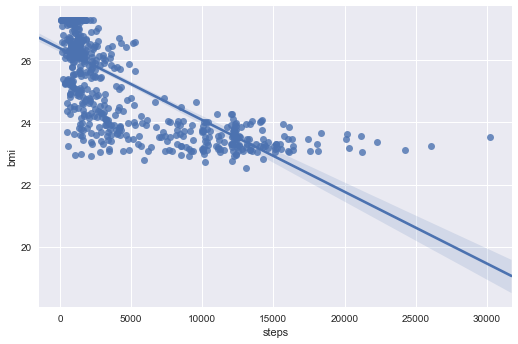

** 95% confidence intervals for the model coefficients **

                   0          1
Intercept  26.267832  26.481559
steps      -0.000246  -0.000214


** Confidence interval interpretation: **If the population from which this sample was drawn     was sampled 100 times, approximately 95 of those confidence intervals would contain the "true" coefficient.

### Hypothesis Test

** Conventional hypothesis **

* Null Hypothesis: There is no relationship bewteen bmi and steps (_b_ = 0)

* Alternative Hypothesis: There is a relationship bewteen bmi and steps (_b_ != 0)

** Testing hypotesis **

The null hypotesis is rejected if:

* the 95% confidence interval does not include zero

The null hypotesis is not rejected if:

* the 95% confidence interval includes zero

** Interpretation **

* Rejecting the null hypotesis means that there is a relationship bewteen bmi and steps

** pvalue **

* Represents the probability that the coefficient is actually zero

* If the 95% confidence interval does not include zero, p-value will be less than 0.05

** Compute pvalues **

* _a_: 0.0

* _b_: 5.316092354334953e-118

** Conclusion **

pvalue for _b_ is less or equal to 0.05, which means the probability that the         coefficient is actually zero is low, and consequently the null hypothesis is rejected,         indicating a relationship bewteen bmi and steps.

In [412]:
regression_analysis(steps_bmi_user)

# Cross Correlation

In [420]:
max_lags = 10 
user_ids = steps_bmi.user_id.unique()
steps_bmi_user_ccorr = {}
steps_bmi_user_lags = {}
i = 0
for user in user_ids:
    i = i+1
    if i%1000 == 0:
        print(i)
    steps_bmi_user = steps_bmi[steps_bmi.user_id==user]
    if(len(steps_bmi_user) < min_entries):
        continue
    a = steps_bmi_user['steps']
    v = steps_bmi_user['bmi']
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    v = (v - np.mean(v)) /  np.std(v)
    cross_corr = plt.xcorr(a, v, maxlags=10)
    corr = cross_corr[1]
    h = np.argmin(corr[:int(len(corr)/2)]) # we are not interested in positive lags.
    steps_bmi_user_ccorr[user] = corr[h]
    steps_bmi_user_lags[user] = abs(cross_corr[0][h])

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


## Individual bmi, steps cross correlation

* _Best correlation:_ -0.7883610391856528

* _Worse correlation:_ 0.7362113761571644

* _Median correlation:_ -0.06689516738163165

* _Mean correlation:_ -0.07773805096241328

* _Standard Deviation:_ 0.15917553749632693 

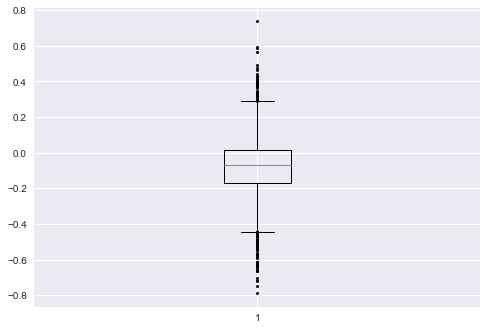

In [440]:
steps_bmi_user_ccorr_values = np.array([v for k,v in steps_bmi_user_ccorr.items()])
printmd('* _Best correlation:_ {}'.format(np.nanmin(steps_bmi_user_ccorr_values)))
printmd('* _Worse correlation:_ {}'.format(np.nanmax(steps_bmi_user_ccorr_values)))
printmd('* _Median correlation:_ {}'.format(np.nanmedian(steps_bmi_user_ccorr_values)))
printmd('* _Mean correlation:_ {}'.format(np.nanmean(steps_bmi_user_ccorr_values)))
printmd('* _Standard Deviation:_ {} '.format(np.nanstd(steps_bmi_user_ccorr_values)))
indexes = ~np.isnan(steps_bmi_user_ccorr_values)
plt.clf()
# there is an issue with matplotlib boxplot fliers not showing up when seaborn is imported
# see solutions at: https://stackoverflow.com/questions/28908003/matplotlib-box-plot-fliers-not-showing
plt.boxplot(steps_bmi_user_ccorr_values[indexes], sym='k.')
plt.show()

In [422]:
user_idx = np.where(steps_bmi_user_ccorr_values[indexes] <= -0.7) [0]
len_users = len(steps_bmi_user_ccorr_values)
printmd('**Number of users with a strong (<=-0.7) negative correlation between steps and bmi: **{} ({}%)'.format(
    len(user_idx), "%.2f" % ( (len(user_idx)/len_users)*100)))

**Number of users with a strong (<=-0.7) negative correlation between steps and bmi: **5 (0.14%)

In [423]:
user_idx = np.where( steps_bmi_user_ccorr_values[indexes] >= 0.7) [0]
printmd('**Number of users with a strong (<=-0.7) positive correlation between steps and bmi: **{} ({}%)'.format(
    len(user_idx), "%.2f" % ( (len(user_idx)/len_users)*100)))


**Number of users with a strong (<=-0.7) positive correlation between steps and bmi: **1 (0.03%)

In [424]:
def scatter_lags(x, y, h):
    x = x[:len(x)-h]
    y = y[-(len(y)-h):]
    plt.scatter(x,y)
    plt.show()
    
def corr_lags(x, y, h):
    x = x[:len(x)-h]
    y = y[-(len(y)-h):]
    print(np.corrcoef(x, y))

## Visualize best case of bmi vs steps lagged correlation

**User: **a27c468d-6fd8-4fba-9ca7-2b6f2c3221d8

**Cross Correlations:**

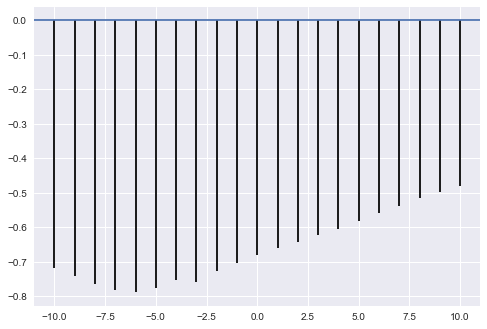

** Min cross Correlation: **: -0.7883610391856528

** Pearson Correlation matrix: **

[[ 1.         -0.80108585]
 [-0.80108585  1.        ]]


**Lag: **: 6

**Scatter plot: **

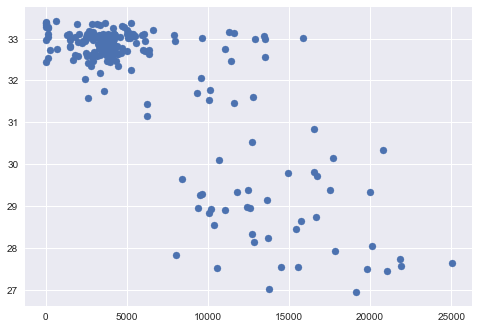

In [425]:
printmd('## Visualize best case of bmi vs steps lagged correlation')
user_id = min(steps_bmi_user_ccorr, key=steps_bmi_user_ccorr.get)
printmd('**User: **{}'.format(user_id))
steps_bmi_user = steps_bmi[steps_bmi.user_id==user_id]

printmd('**Cross Correlations:**')
a = steps_bmi_user['steps']
v = steps_bmi_user['bmi']
a = (a - np.mean(a)) / (np.std(a) * len(a))
v = (v - np.mean(v)) /  np.std(v)
cross_corr = plt.xcorr(a, v, maxlags=10)
plt.show()

printmd('** Min cross Correlation: **: {}'.format(steps_bmi_user_ccorr[user_id]))
printmd('** Pearson Correlation matrix: **')
x = steps_bmi_user['steps']
y = steps_bmi_user['bmi']
corr_lags(x, y, steps_bmi_user_lags[user_id])

printmd('**Lag: **: {}'.format(steps_bmi_user_lags[user_id]))

printmd('**Scatter plot: **')
scatter_lags(x, y, steps_bmi_user_lags[user_id])

## Regression Analysis

** The regression model is defined as: **bmi = _a_ + _b_ steps

** Linear regression coefficients: **

* _a_ = 33.41413457431116

* _b_ = -0.0002191540667318059

** Linear regression predictions: **

* Steps: 2000, Bmi_pred: 32.97582644084755

* Steps: 5000, Bmi_pred: 32.31836424065213

* Steps: 10000, Bmi_pred: 31.222593906993104

**Plot the Least Squares Line**

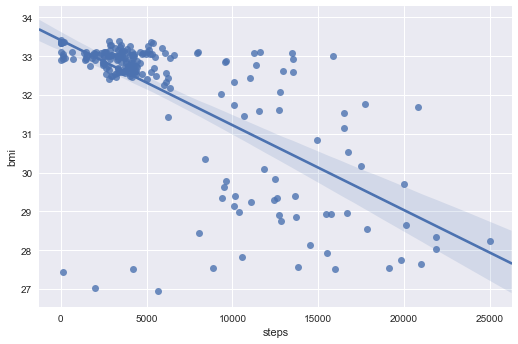

** 95% confidence intervals for the model coefficients **

                   0          1
Intercept  33.149305  33.678965
steps      -0.000251  -0.000187


** Confidence interval interpretation: **If the population from which this sample was drawn     was sampled 100 times, approximately 95 of those confidence intervals would contain the "true" coefficient.

### Hypothesis Test

** Conventional hypothesis **

* Null Hypothesis: There is no relationship bewteen bmi and steps (_b_ = 0)

* Alternative Hypothesis: There is a relationship bewteen bmi and steps (_b_ != 0)

** Testing hypotesis **

The null hypotesis is rejected if:

* the 95% confidence interval does not include zero

The null hypotesis is not rejected if:

* the 95% confidence interval includes zero

** Interpretation **

* Rejecting the null hypotesis means that there is a relationship bewteen bmi and steps

** pvalue **

* Represents the probability that the coefficient is actually zero

* If the 95% confidence interval does not include zero, p-value will be less than 0.05

** Compute pvalues **

* _a_: 1.9284891564512365e-263

* _b_: 1.683768114427747e-30

** Conclusion **

pvalue for _b_ is less or equal to 0.05, which means the probability that the         coefficient is actually zero is low, and consequently the null hypothesis is rejected,         indicating a relationship bewteen bmi and steps.

In [426]:
regression_analysis(steps_bmi_user)